In [21]:
import numpy as np
from math import ceil
from scipy.sparse import dok_matrix
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
class Coord:
    def __init__(self, x=0, y=0):
        self.x = x
        self.y = y
    def __repr__(self):
        return "({},{})".format(self.x, self.y)

class Rayo:
    def __init__(self, inicio, fin):
        self.inicio = inicio
        self.fin = fin
    def __repr__(self):
        return "({},{})".format(self.inicio, self.fin)

In [3]:
def coordenadasDeRayo(r):
    res = set()
    
    inicio = r.inicio
    fin = r.fin

    deltaX = fin.x - inicio.x
    deltaY = fin.y - inicio.y
    curY = inicio.y
    curX = inicio.x
    res.add(inicio)

    stepX = 1
    stepY = 1
    
    if deltaX < 0:
        stepX = -1
        deltaX = -deltaX
    if deltaY < 0:
        stepY = -1
        deltaY = -deltaY

    dobleDX = 2 * deltaX
    dobleDY = 2 * deltaY

    if dobleDX >= dobleDY:
        # Pendiente menor a identidad
        ultError = deltaX
        error = deltaX

        for i in range(deltaX):
            curX += stepX
            error += dobleDY

            if error > dobleDX:
                curY += stepY
                error -= dobleDX
 
            if error + ultError < dobleDX:
                res.add(Coord(curX, curY - stepY))
            elif error + ultError > dobleDX:
                res.add(Coord(curX - stepX, curY))
            
            res.add(Coord(curX, curY))
            ultError = error
    else:
        # Pendiente mayor a identidad
        ultError = deltaY
        error = deltaY
        for i in range(deltaY):
            curY += stepY
            error += dobleDX

            if error > dobleDY:
                curX += stepX
                error -= dobleDY
                if error + ultError < dobleDY:
                    res.add(Coord(curX - stepX, curY))
                elif error + ultError > dobleDY:
                    res.add(Coord(curX, curY - stepY))
            res.add(Coord(curX, curY))
            ultError = error
    return res

In [4]:
# generacion de rayos
def generar_rayos(img, width, step):
    n = img.shape[0] -1
    m = img.shape[1] -1
    tc = []

    for base in range(0, n, step):
        endX = max(0, base - width)
        while endX <= min(m, base + width):
            tc.append(Rayo(Coord(base, 0), Coord(endX, m)))
            tc.append(Rayo(Coord(base, m), Coord(endX, 0)))
            endX += 1

    for base in range(0, m, step):
        endY = max(0, base - width)
        while endY <= min(n, base + width):
            tc.append(Rayo(Coord(0, base), Coord(n, endY)))
            tc.append(Rayo(Coord(n, base), Coord(0, endY)))
            endY += 1
            
    return tc;

In [53]:
# generacion de rayos
def generar_rayos_bis(img, width, step, step_other_side):
    n = img.shape[0] -1
    m = img.shape[1] -1
    tc = []

    for base in range(0, n, step):
        endX = max(0, base - width)
        while endX <= min(m, base + width):
            tc.append(Rayo(Coord(base, 0), Coord(endX, m)))
            tc.append(Rayo(Coord(base, m), Coord(endX, 0)))
            endX += step_other_side

    for base in range(0, m, step):
        endY = max(0, base - width)
        while endY <= min(n, base + width):
            tc.append(Rayo(Coord(0, base), Coord(n, endY)))
            tc.append(Rayo(Coord(n, base), Coord(0, endY)))
            endY += step_other_side
            
    return tc;

124


[]

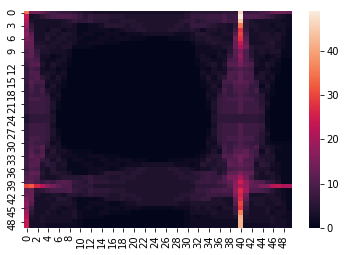

In [52]:
matriz = np.matrix([[0] * 50 for i in range(50)])
rayos = generar_rayos_bis(matriz, 10, 40,3)
print(len(rayos))
for rayo in rayos:
    for coor in coordenadasDeRayo(rayo):
        matriz[coor.x,coor.y] += 1
sns.heatmap(matriz)
plt.plot()

44


[]

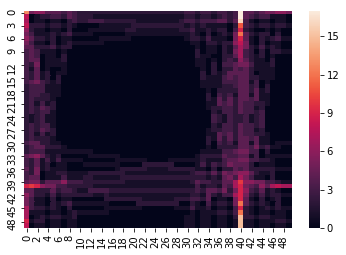

In [54]:
matriz = np.matrix([[0] * 50 for i in range(50)])
rayos = generar_rayos_bis(matriz, 10, 40,3)
print(len(rayos))
for rayo in rayos:
    for coor in coordenadasDeRayo(rayo):
        matriz[coor.x,coor.y] += 1
sns.heatmap(matriz)
plt.plot()

In [5]:
# calculo de tiempos
def calcular_tiempos(img, rayos):
    tiempos = []
    for r in rayos:
        velocidad = 0;
        puntos = coordenadasDeRayo(r)
        for celda in puntos:
            elem = img[celda.x][celda.y]
            if elem != 0:
                velocidad += elem
        tiempos.append(velocidad)
    return tiempos;

In [6]:
def pixel_real_a_discretizado(real, magnitud_discretizacion):
    coor = Coord(real.x // magnitud_discretizacion,
                 real.y // magnitud_discretizacion);
    return coor

In [7]:
def generarDiscretizacion(img_original, rayos, magnitud_discretizacion):
    tamanio_discretizacion = ceil(img_original.shape[0] / float(magnitud_discretizacion))
    shape = (len(rayos), tamanio_discretizacion**2)
    matriz_sist = dok_matrix(shape)

    for i in range(len(rayos)):
        for coord in coordenadasDeRayo(rayos[i]):
            coordDiscretizada = pixel_real_a_discretizado(coord, magnitud_discretizacion)
            matriz_sist[i, coordDiscretizada.x * tamanio_discretizacion + coordDiscretizada.y] = 1
    return matriz_sist

In [8]:
def vec_to_matrix(elems, n, m):
    matriz = [[0] * m] * n
    for i in range(n):
        for j in range(m):
            matriz[i][j] = elems[m * i + j]
    return matriz

In [9]:
#Main
# defino parametros
magnitud_discretizacion = 4
varianza_ruido = 0
width_rayos = 50
step_rayos = 4
img_inicial = np.genfromtxt('img_csv/tomo.csv', delimiter=',')

rayos = generar_rayos(img_inicial, width_rayos, step_rayos)
print("Calculando tiempos")
tiempos = calcular_tiempos(img_inicial, rayos)
print("Generando discretizacion")
matriz_sistema = generarDiscretizacion(img_inicial, rayos, magnitud_discretizacion)

print("Cuadrados Minimos")
solucion_cm = np.linalg.lstsq(matriz_sistema.toarray(), tiempos, rcond=None)
tamanio_discretizacion = ceil(img_inicial.shape[0] / float(magnitud_discretizacion))

solucion = vec_to_matrix(solucion_cm[0], tamanio_discretizacion, tamanio_discretizacion);

Calculando tiempos
Generando discretizacion
Cuadrados Minimos


In [13]:
from PIL import Image
import numpy as np
import sys
import os
import csv
import scipy.misc

imagen_numpy = solucionescalada
imagen = scipy.misc.toimage(imagen_numpy, cmin=0.0)
print("Dimensiones:", imagen.size)
imagen.show()

Dimensiones: (25, 25)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  if __name__ == '__main__':


In [11]:
maxi = -100000
mini = 10000000
for row in solucion:
    for elem in row:
        if elem > maxi:
            maxi = elem
        if elem < mini:
            mini = elem
print(mini, maxi)

-1682.2153053216298 3198.5733276275787


In [12]:
rangoviejo = maxi - mini
nuevorango = 255
solucionescalada = [[0] * len(solucion[0])] * len(solucion)
for i in range(len(solucion)):
    for j in range(len(solucion[i])):
        solucionescalada[i][j] =(((solucion[i][j] - mini) * nuevorango) / rangoviejo)


In [113]:
solucionescalada

[[146.32603646434228,
  36.88894599943973,
  0.0,
  140.7705724156351,
  126.68356972279055,
  133.15695958968982,
  138.54680595367375,
  131.64646147672727,
  131.94895668934126,
  138.4100807813557,
  132.4526021866416,
  128.4405902072872,
  139.11556021765472,
  131.2868727832767,
  131.62522319417286,
  143.20252579993053,
  131.5634653815176,
  131.4304007929733,
  137.82435296179338,
  129.59804244175615,
  117.15966132570294,
  138.22644948776042,
  255.0,
  116.08346059840984,
  120.26419636438851],
 [146.32603646434228,
  36.88894599943973,
  0.0,
  140.7705724156351,
  126.68356972279055,
  133.15695958968982,
  138.54680595367375,
  131.64646147672727,
  131.94895668934126,
  138.4100807813557,
  132.4526021866416,
  128.4405902072872,
  139.11556021765472,
  131.2868727832767,
  131.62522319417286,
  143.20252579993053,
  131.5634653815176,
  131.4304007929733,
  137.82435296179338,
  129.59804244175615,
  117.15966132570294,
  138.22644948776042,
  255.0,
  116.083460598